In [190]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse
import random
import seaborn as sns
sns.set(style="whitegrid")
import collections 

## Problem 1.1 - Epidemics over symmetric graphs

You should simulate an epidemic on a symmetric k-regular graph with 500 nodes and k = 4. Let $\beta=3$ and $\rho$=0.7.
With one week being one unit of time, simulate the epidemic for 15 weeks. You can choose an initial configuration with 10 infected nodes selected at random from the node set V, or make a different choice of initial configuration (in the latter case, please briefly discuss your motivation).

$\rho$ is the probability that at one time step an infected I individual recovers becoming state R (mutation kernel).

$\beta$ is the probability that a susceptible S becomes and infected I based on the number of infected neighbors.

In [390]:
def draw_k_symmetric(n=8,k=4):
    G = nx.Graph()
    for i in range(n-2):
        G.add_edge(i, i+1)
        G.add_edge(i, i+2)
    G.add_edge(n-2, n-1)
    G.add_edge(n-2, 0)
    G.add_edge(n-1, 0)
    G.add_edge(n-1, 1)
    
    #nx.draw_circular(G, with_labels = True)
    
    return G

G = draw_k_symmetric(500)
print(G)

Graph with 500 nodes and 1000 edges


In [391]:
def simulate_epidemics(graph, n_infected=10, beta=0.3, rho=0.7, n_weeks=15, n_simulation=100,
                      flg_vaccine = False, 
                      vax_campaign = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]):
    
    # S=0, I=1, R=2
    G = graph
    # Number of agents, the number of nodes in the graph
    n_agents = len(G)

    tot_susceptible = np.zeros(n_weeks, dtype=int)
    tot_infected = np.zeros(n_weeks, dtype=int)
    tot_recovered = np.zeros(n_weeks, dtype=int)
    tot_new_infection = np.zeros(n_weeks, dtype=int)
    
    if flg_vaccine == True:
        fract_to_vax = [abs(prev-succ) for prev, succ in zip(vax_campaign, vax_campaign[1:])] + [0]
        tot_vaccinated = np.zeros(n_weeks, dtype=int)
        tot_new_vaccinated = np.zeros(n_weeks, dtype=int)

    for i in range(n_simulation):
        # Initial configuration with random 10 infected nodes
        status = np.zeros(n_agents, dtype=int)
        initial_contagion = random.sample(list(np.arange(n_agents)), n_infected)
        for ix in initial_contagion:
            status[ix] = 1

        susceptible = [n_agents-n_infected]
        infected = [n_infected]
        recovered = [0]
        new_infection = []
        
        if flg_vaccine == True:
            vaccinated = []
            new_vaccination = []         

        curr_state = status.copy()

        for week in range(n_weeks):
            prev_state = curr_state.copy()
            
            if flg_vaccine == True:
                new_vax = 0
                not_vaccinated = np.argwhere(prev_state!=3).squeeze()
                number_to_vax = round(n_agents/100*fract_to_vax[week])
                people_to_vax = np.random.choice(not_vaccinated, size=number_to_vax, replace=False)
                for p in people_to_vax:
                    prev_state[p] = 3
                    new_vax += 1
                new_vaccination.append(new_vax)
                vaccinated.append(len(np.argwhere(prev_state == 3)))
        
            curr_state = prev_state.copy()
            
            new_infect = 0      
            for node in range(n_agents):
                # If the node is susceptible
                if prev_state[node] == 0:
                    # compute the number of infected neighbors
                    neighbors = [i for i in G.neighbors(node)]
                    infect = sum(list(filter(lambda k:k==1, prev_state[neighbors])))
                    # compute the probability of infection
                    prob_infection = 1 - (1-beta)**infect
                    if np.random.rand() < prob_infection:
                        # infected!
                        curr_state[node] = 1
                        new_infect += 1
                # If the node is infected
                elif prev_state[node] == 1:
                    # probability of recover is rho = 0.7
                    if np.random.rand() < rho:
                        # recoved!
                        curr_state[node] = 2
            new_infection.append(new_infect)
            susceptible.append(len(np.argwhere(curr_state == 0)))
            infected.append(len(np.argwhere(curr_state == 1)))
            recovered.append(len(np.argwhere(curr_state == 2)))

        tot_susceptible = [sum(s) for s in zip(tot_susceptible, susceptible)]
        tot_infected = [sum(s) for s in zip(tot_infected, infected)]
        tot_recovered = [sum(s) for s in zip(tot_recovered, recovered)]
        tot_new_infection = [sum(s) for s in zip(tot_new_infection, new_infection)]
        if flg_vaccine == True:
            tot_vaccinated = [sum(s) for s in zip(tot_vaccinated, vaccinated)]
            tot_new_vaccinated = [sum(s) for s in zip(tot_new_vaccinated, new_vaccination)]

    avg_susceptible = [x/n_simulation for x in tot_susceptible]
    avg_infected = [x/n_simulation for x in tot_infected]
    avg_recovered = [x/n_simulation for x in tot_recovered]
    avg_new_infection = [x/n_simulation for x in tot_new_infection]
    if flg_vaccine == True:
        avg_vaccinated = [x/n_simulation for x in tot_vaccinated]
        avg_new_vaccinated = [x/n_simulation for x in tot_new_vaccinated]
        
    if flg_vaccine == True:
        return avg_susceptible, avg_infected, avg_recovered, avg_new_infection, avg_vaccinated, avg_new_vaccinated
    else:
        return avg_susceptible, avg_infected, avg_recovered, avg_new_infection

In [424]:
def epidemics_statistics(n_week, avg_susceptible, avg_infected, avg_recovered, avg_new_infection,
                         avg_vaccinated=[],avg_new_vaccinated=[],flg_vaccine = False):

    print("avg susceptible:")
    print(avg_susceptible)
    print("avg infected:")
    print(avg_infected)
    print("avg recovered:")
    print(avg_recovered)
    print("avg new infection:")
    print(avg_new_infection)
    
    if flg_vaccine == True:
        print("avg vaccinated:")
        print(avg_vaccinated)
        print("avg new vaccinated:")
        print(avg_new_vaccinated)
           
    fig, (ax1, ax2)= plt.subplots(2,1,figsize=(15,12))
    x = list(np.arange(15))

    #plt.plot(x, avg_susceptible, label="average susceptible") 
    ax1.plot(x, avg_infected, label="average infected", color = 'red', linewidth=3) 
    ax1.plot(x, avg_recovered, label="average recovered", color = 'green', linewidth=3) 
    ax1.plot(x, avg_new_infection, label="average new_infection", color = 'magenta', linestyle='--'
             , linewidth=3) 
    if flg_vaccine == True:
        ax2.plot(x, avg_vaccinated, label="average vaccinated", color = 'darkviolet', 
                 linestyle='dashed', linewidth=3)
        ax2.plot(x, avg_new_vaccinated, label="average new vaccinated", color = 'darkorange',
                 linestyle='dashed', linewidth=3)

    ax1.tick_params(axis='x', labelsize=17)
    ax1.tick_params(axis='y', labelsize=17)
    ax1.legend(fontsize=17)

    ax2.plot(x, avg_susceptible, label="average susceptible", color = 'blue', linewidth=3) 
    ax2.tick_params(axis='x', labelsize=17)
    ax2.tick_params(axis='y', labelsize=17)
    ax2.legend(fontsize=17)

    plt.show()

avg susceptible:
[490.0, 477.92, 467.39, 459.39, 453.84, 449.99, 447.05, 445.18, 443.78, 442.87, 442.17, 441.63, 441.37, 441.15, 440.96]
avg infected:
[10.0, 14.84, 14.96, 12.37, 9.12, 6.54, 4.74, 3.23, 2.38, 1.57, 1.28, 0.95, 0.54, 0.34, 0.25]
avg recovered:
[0.0, 7.24, 17.65, 28.24, 37.04, 43.47, 48.21, 51.59, 53.84, 55.56, 56.55, 57.42, 58.09, 58.51, 58.79]
avg new infection:
[12.08, 10.53, 8.0, 5.55, 3.85, 2.94, 1.87, 1.4, 0.91, 0.7, 0.54, 0.26, 0.22, 0.19, 0.11]


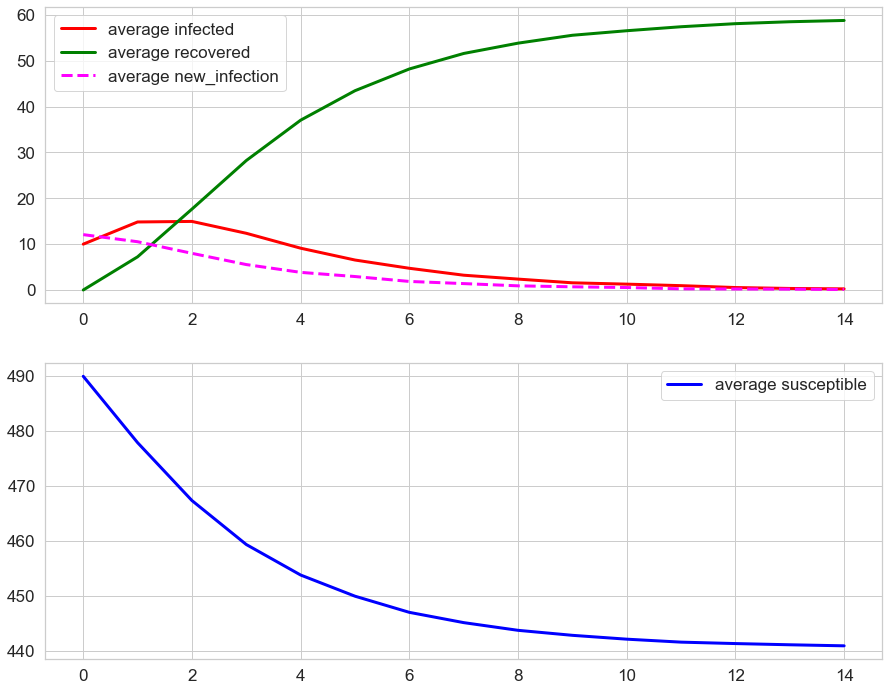

In [405]:
avg_susceptible, avg_infected, avg_recovered, avg_new_infection = simulate_epidemics(G)
epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, avg_new_infection)

## Problem 1.2 - Preferential Attachment Random Graph

In [394]:
def create_random_graph(n=40, k=7):
    
    GPA = nx.complete_graph(k+1)
    
    for node in range(k+1, n):
        if k % 2 == 1:
            # if k is uneven take alternatively the floor and ceil of the number
            if node % 2 == 0:
                d = int(np.floor(k/2))
            else:
                d = int(np.ceil(k/2))
        else:
            # k is even
            d = int(k/2)
        
        deg_PA = [d for n, d in GPA.degree()]
        probabilities = np.array(deg_PA)/sum(deg_PA)
        #print(deg_PA)
        # replace=False guarantees no neighbor is chosen twice
        neighbors = np.random.choice(np.arange(len(GPA)), p=probabilities, size=d, replace=False)
        GPA.add_node(node)
        # add the new links 
        for neigh in neighbors:
            GPA.add_edge(node,neigh)   

    #nx.draw_circular(GPA, with_labels = True)
    deg_PA = [d for n, d in GPA.degree()]
    #print()
    print("number of nodes: ", len(GPA))
    print("average degree: ", sum(deg_PA)/len(GPA))
    
    return GPA

In [395]:
create_random_graph(910, 7)    

number of nodes:  910
average degree:  7.0


## Problem 2 - Simulate a pandemic without vaccination

In [396]:
G2 = create_random_graph(500, 6)  

number of nodes:  500
average degree:  6.0


avg susceptible:
[490.0, 472.19, 412.09, 303.74, 201.92, 139.79, 110.79, 98.52, 93.42, 91.58, 90.91, 90.62, 90.51, 90.42, 90.36]
avg infected:
[10.0, 20.44, 66.08, 127.57, 140.51, 104.43, 61.28, 30.61, 14.22, 6.32, 2.62, 1.02, 0.4, 0.16, 0.12]
avg recovered:
[0.0, 7.37, 21.83, 68.69, 157.57, 255.78, 327.93, 370.87, 392.36, 402.1, 406.47, 408.36, 409.09, 409.42, 409.52]
avg new infection:
[17.81, 60.1, 108.35, 101.82, 62.13, 29.0, 12.27, 5.1, 1.84, 0.67, 0.29, 0.11, 0.09, 0.06, 0.02]


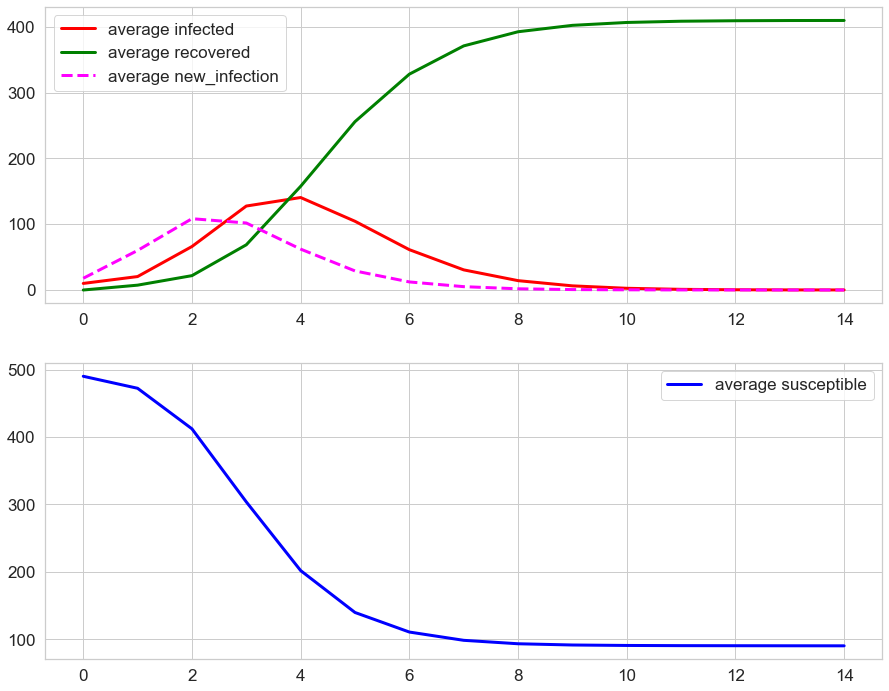

In [425]:
avg_susceptible, avg_infected, avg_recovered, avg_new_infection = simulate_epidemics(G2)
epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, avg_new_infection)

## Problem 3 - Simulate a pandemic with vaccination

In [398]:
G3 = create_random_graph(500, 6)  

number of nodes:  500
average degree:  6.0


avg susceptible:
[490.0, 450.55, 358.74, 258.1, 180.67, 132.4, 101.19, 87.56, 86.37, 85.92, 85.67, 85.6, 85.57, 85.5, 85.42]
avg infected:
[10.0, 17.66, 49.09, 70.9, 61.91, 35.97, 15.93, 6.78, 3.21, 1.5, 0.78, 0.32, 0.17, 0.13, 0.14]
avg recovered:
[0.0, 6.79, 17.17, 46.0, 82.42, 106.63, 107.88, 105.66, 110.42, 112.58, 113.55, 114.08, 114.26, 114.37, 114.44]
avg new infection:
[14.93, 44.61, 58.25, 43.35, 20.81, 7.33, 2.45, 1.19, 0.45, 0.25, 0.07, 0.03, 0.07, 0.08, 0.05]
avg vaccinated:
[25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
avg new vaccinated:
[25.0, 50.0, 50.0, 50.0, 50.0, 50.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


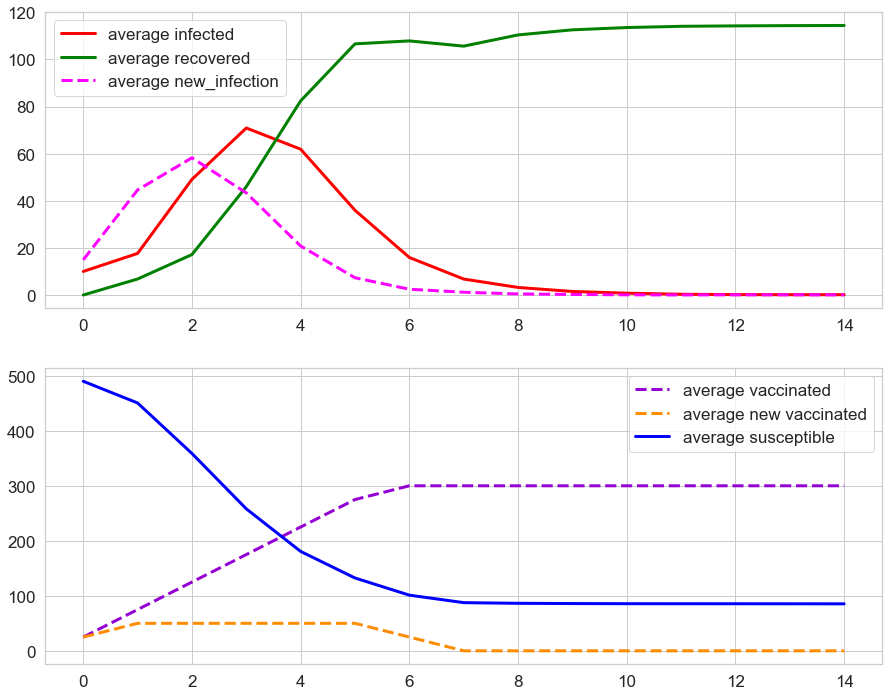

In [426]:
vax_campaign = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
(avg_susceptible, avg_infected, avg_recovered, avg_new_infection, 
 avg_vaccinated, avg_new_vaccinated) = simulate_epidemics(G3,n_infected=10, 
                                                          beta=0.3, rho=0.7, 
                                                          n_weeks=15, n_simulation=100,
                                                          flg_vaccine = True, 
                                                          vax_campaign = vax_campaign)

epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, 
                     avg_new_infection, avg_vaccinated, avg_new_vaccinated, flg_vaccine = True)

## Below trash

In [379]:
lis = np.array([1, 1, 3, 2, 2, 3, 2])
print(np.argwhere(lis!=3).squeeze())

[0 1 3 4 6]


In [377]:
print([x for x in lis if x != 3])

[1, 1, 2, 2, 2]


In [383]:
u = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
test = [abs(prev-succ) for prev, succ in zip(u, u[1:])]
print(test)
print(np.random.choice(test, size=4, replace=False))

[5, 10, 10, 10, 10, 10, 5, 0, 0, 0, 0, 0, 0, 0]
[ 0 10  0  0]


In [144]:
x = [10, 2,3]
y = [10, 2,3]
[sum(j) for j in zip(x, y)]

[20, 4, 6]